# Some content for playing with Gaussian processes

I have tried to show some of the basic Gaussian process computations, as well as how to use popular packages to conduct them.

In [2]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.linalg import cho_solve, cho_factor, solve_triangular
import matplotlib.pyplot as plt
%matplotlib inline

$\newcommand{\kk}{\mathbf{k}}\newcommand{\xx}{\mathbf{x}}\newcommand{\yy}{\mathbf{y}}
\newcommand{\mK}{\mathsf{K}}\newcommand{\mI}{\mathsf{I}}\newcommand{\mD}{\mathsf{D}}$

First, it will help to create a Gaussian process object with some standard functions in it.

We will assume certain properties about our Gaussian process:
* It should have a zero mean
* It should have a Gaussian covariance kernel
* The Gaussian covariance should have individual length scales for each dimension
* There is a fixed Gaussian uncertainty/noise associated with each observation (equivalent to a Tikhonov parameter)
* There is a process variance which 

You can absolutely permit other properties (as discussed in my [textbook](https://www.worldscientific.com/worldscibooks/10.1142/9335)) but we are keeping it simple here for right now because this is enough to show something interesting.

In general, I do not recommend putting this together yourself; I am only doing it here to show what some of the core computations look like.  You are certainly welcome to, but there are other pieces of software that you can use to do this -- and those libraries have been developed and tested by a number of experts.  Of course, if you are doing research on GPs, it may behoove you to have your own code to work with and manipulate.

The two key computations taking place are
\begin{align}
\text{mean at $\xx$} &= \kk(\xx)^\top\left(\mK + \sigma_o^2 \mI_n\right)^{-1}\yy \\
\text{variance at $\xx$} &= K(\xx, \xx) - \kk(\xx)^\top\left(\mK + \sigma_o^2 \mI_n\right)^{-1}\kk(\xx)
\end{align}

where

\begin{align}
K(\xx, \xx) = \exp\left(-\xx^T\mD^{-2}\xx\right),\qquad
\kk(\xx) = \begin{pmatrix}K(\xx, \xx_1)\\\vdots\\K(\xx, \xx_n)\end{pmatrix},\qquad
\mK = \begin{pmatrix}&&\\\kk(\xx_1)&\cdots&\kk(\xx_n)\\&&\end{pmatrix},
\end{align}

and $\xx_i$ and $y_i$ are the $i$th $\xx$ and $y$ values that have been observed ($\xx$ is a $d$ dimensional vector), and $\mD$ is a diagonal matrix with the length scales on the diagonal.

In [3]:
class GaussianProcess(object):
    def __init__(self, x, y, process_variance, length_scales, observation_noise):
        length_scales = np.array(length_scales)
        x = np.array(x)
        y = np.array(y)
        assert process_variance > 0 and observation_noise >= 0 and all(length_scales > 0)
        assert len(x.shape) == 2 and len(y.shape) == 1 and len(length_scales) == x.shape[1] and x.shape[0] == len(y)
        
        self.x = x
        self.y = y
        self.length_scales = length_scales
        self.process_variance = process_variance
        self.observation_noise = observation_noise
        
        self._distance_matrix_weights = 1 / self.length_scales ** 2
        self._interpolation_weights = None
        self._K_chol = None
        self._initialize()
        
    @property
    def dim(self):
        return self.x.shape[1]
        
    @property
    def num_points(self):
        return self.x.shape[0]
        
    def _initialize(self):
        K = self.compute_covariance(self.x, self.x)
        self._K_chol = cho_factor(K + np.eye(self.num_points) * self.observation_noise, lower=True, overwrite_a=True)
        self._interpolation_weights = cho_solve(self._K_chol, self.y)
    
    def _distance_matrix_squared(self, x, z):
        return cdist(x, z, w=self._distance_matrix_weights, metric='sqeuclidean')
    
    def compute_covariance(self, x, z):
        r_squared = self._distance_matrix_squared(x, z)
        return self.process_variance * np.exp(-r_squared)
    
    def posterior_mean(self, x):
        K_eval = self.compute_covariance(x, self.x)
        return np.dot(K_eval, self._interpolation_weights)
    
    def posterior_variance(self, x):
        K_eval = self.compute_covariance(x, self.x)
        symmetric_term = solve_triangular(self._K_chol[0], K_eval.T, lower=self._K_chol[1], overwrite_b=True)
        schur_complement_term = np.sum(symmetric_term ** 2, axis=0)
        return np.fmax(1e-20, self.process_variance - schur_complement_term)

Choosing Gaussian process parameters (`process_variance`, `length_scales`, `observation_noise`) can be tricky.  This is often done with Maximum Likelihood Estimation, but we will just fix the values right now (rather than try to learn them).

The problem below is an example function called the Franke function.

In [4]:
def yf(x):
    x1, x2 = x.T
    return (
        .75 * np.exp(-.25 * ((9 * x1 - 2) ** 2 + (9 * x2 - 2) ** 2)) +
        .75 * np.exp(-(9 * x1 + 1) ** 2 / 49 - (9 * x2 + 1) / 10) +
        .5 * np.exp(-.25 * ((9 * x1 - 7) ** 2 + (9 * x2 - 3) ** 2)) -
        .2 * np.exp(-(9 * x1 - 4) ** 2 - (9 * x2 - 7) ** 2)
    )

Np = (35, 34)
X0, X1 = np.meshgrid(np.linspace(0, 1, Np[1]), np.linspace(0, 1, Np[0]))
xp = np.array([X0.reshape(-1), X1.reshape(-1)]).T
yp = yf(xp)
Y = yp.reshape(Np)

Now we try to fit a GP to randomly scattered data throughout the domain and see how it looks relative to the true function.

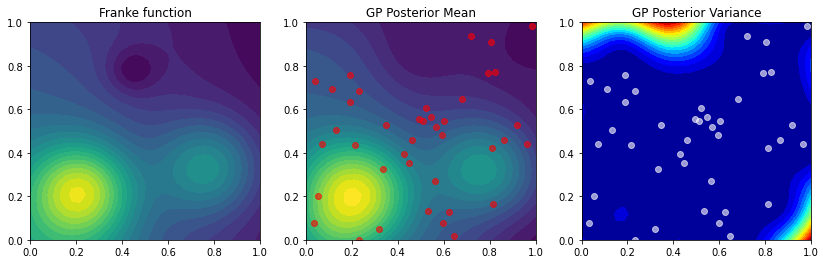

In [41]:
x = np.random.random((40, 2))
y = yf(x)

process_variance = 1.0
length_scales = [.3, .3]
observation_noise = 1e-5
gaussian_process = GaussianProcess(x, y, process_variance, length_scales, observation_noise)

ym = gaussian_process.posterior_mean(xp)
yv = gaussian_process.posterior_variance(xp)
YM = ym.reshape(Np)
YV = yv.reshape(Np)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

ax = axes[0]
ax.contourf(X0, X1, Y, 20)
ax.set_title('Franke function')

ax = axes[1]
ax.contourf(X0, X1, YM, 20, vmin=0.00114, vmax=1.22)
ax.plot(x[:, 0], x[:, 1], 'or', alpha=.6)
ax.set_title('GP Posterior Mean')

ax = axes[2]
h = ax.contourf(X0, X1, YV, 20, cmap='jet')
ax.plot(x[:, 0], x[:, 1], 'ow', alpha=.6)
ax.set_title('GP Posterior Variance');

# Now, we can show the same outcomes using popular libraries

In particular, the [GPy](https://gpy.readthedocs.io/en/deploy/) and [Botorch](https://botorch.org/docs/introduction) libraries are popular for people trying to build Gaussian Process models.

Botorch is shown first.  It is derived from GPyTorch, a library developed primarily at Cornell but is being supported heavily by Facebook.  Botorch is mostly for developers more than practitioners to use ([Ax](https://ax.dev/) is the tool which provides a cleaner interface for practitioners).

Note that we are allowing Botorch to `fit_gpytorch_model`.  In doing so, it chooses the model that makes the most sense based on the data that has been observed.  The behavior will not be terribly different than what we saw above because there is a lot of data relative to the dimension.

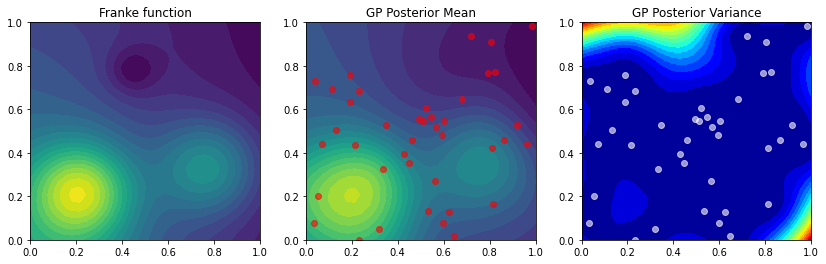

In [42]:
import torch
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels.rbf_kernel import RBFKernel
from botorch.models.gp_regression import SingleTaskGP

gp = SingleTaskGP(torch.tensor(x), torch.tensor(y[:, None]))
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll)

ym = gp.posterior(torch.tensor(xp)).mean
yv = gp.posterior(torch.tensor(xp)).variance
YM = ym.detach().numpy().reshape(Np)
YV = yv.detach().numpy().reshape(Np)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

ax = axes[0]
ax.contourf(X0, X1, Y, 20)
ax.set_title('Franke function')

ax = axes[1]
ax.contourf(X0, X1, YM, 20, vmin=0.00114, vmax=1.22)
ax.plot(x[:, 0], x[:, 1], 'or', alpha=.6)
ax.set_title('GP Posterior Mean')

ax = axes[2]
h = ax.contourf(X0, X1, YV, 20, cmap='jet')
ax.plot(x[:, 0], x[:, 1], 'ow', alpha=.6)
ax.set_title('GP Posterior Variance');

The GPy library is a bit older but, perhaps, a bit easier to make some simple things occur.  It does lack some of the power and flexibility afforded by Botorch/GPytorch (especially if trying to conduct work on GPUs, which is naturally handled by Botorch).

c:\users\mike\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


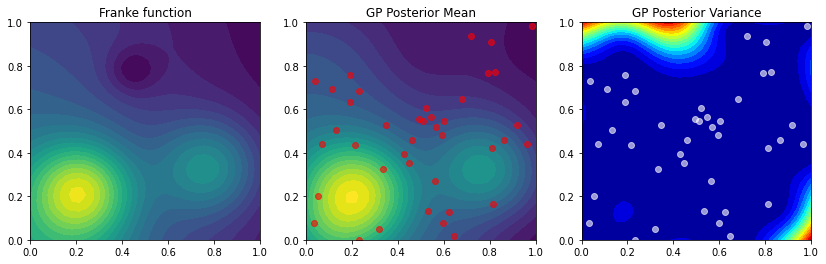

In [43]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = (
    process_variance * RBF(length_scale=np.sqrt(.5) * length_scales[0], length_scale_bounds="fixed") +
    WhiteKernel(noise_level=observation_noise)
)
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(x, y)

ym, yv_sqrt = gp.predict(xp, return_std=True)
yv = yv_sqrt ** 2
YM = ym.reshape(Np)
YV = yv.reshape(Np)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

ax = axes[0]
ax.contourf(X0, X1, Y, 20)
ax.set_title('Franke function')

ax = axes[1]
ax.contourf(X0, X1, YM, 20, vmin=0.00114, vmax=1.22)
ax.plot(x[:, 0], x[:, 1], 'or', alpha=.6)
ax.set_title('GP Posterior Mean')

ax = axes[2]
h = ax.contourf(X0, X1, YV, 20, cmap='jet')
ax.plot(x[:, 0], x[:, 1], 'ow', alpha=.6)
ax.set_title('GP Posterior Variance');